## Exercise 1.4 Hotdog -- no hotdog
This is the poster hand-in project for the course. Please see the associated PDF for instructions.

In [1]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm import tqdm
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import torchvision.models as models
from torchvision.models import ResNet18_Weights

os.makedirs('figures', exist_ok=True)

We always check that we are running on a GPU

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [3]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='./data_hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
 
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [4]:
size = 224
batch_size = 64

# Use ImageNet normalization (important for pretrained ResNet)
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])
train_augment = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.RandomRotation(25),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])
test_transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

trainset_aug = Hotdog_NotHotdog(train=True, transform=train_augment)
train_loader_aug = DataLoader(trainset_aug, batch_size=batch_size, shuffle=True)

testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

Let's look at some images from our data 

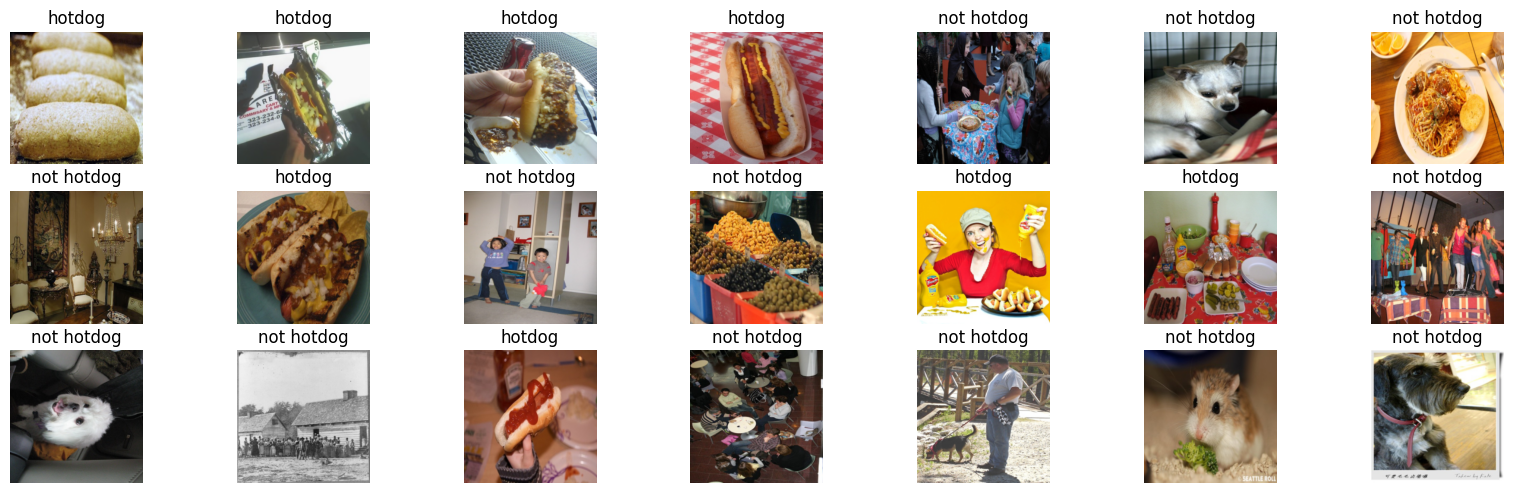

In [5]:
# Explanation: Normalization (transforms.Normalize) shifts pixel values so tensors are no longer in [0,1].
# Matplotlib's imshow expects RGB floats in [0,1] (or 0-255 ints); to visualize, unnormalize back to [0,1] before plotting.

def unnormalize_img(img_tensor, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]):
    """Convert a normalized torch tensor (C,H,W) to a HxWxC numpy array in [0,1] for plt.imshow."""
    # img_tensor: torch.Tensor on cpu, shape (C,H,W)
    img = img_tensor.detach().cpu().numpy().copy()
    for c in range(3):
        img[c] = img[c] * std[c] + mean[c]
    img = np.clip(img, 0.0, 1.0)
    # C,H,W -> H,W,C
    img = np.transpose(img, (1,2,0))
    return img

images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    # plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    img = unnormalize_img(images[i])
    plt.imshow(img)
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')

Now create a model and train it!


In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 8, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(8, 16, 3, 1, 1),
            nn.ReLU(),
        )

        self.fully_connected = nn.Sequential(
            nn.Linear(size**2 * 16 // 4, 500),
            nn.ReLU(),
            nn.Linear(500, 2)
        )

    def forward(self, x):
        x = self.convolutional(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fully_connected(x)
        return x

class AdvancedCNN(SimpleCNN):
    def __init__(self):
        super().__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 8, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(8, 16, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3, 1, 1),
            nn.ReLU()
        )

        self.fully_connected = nn.Sequential(
            nn.Linear(size**2 * 32 // 4 // 4, 500),
            nn.ReLU(),
            nn.Linear(500, 2)
        )

class AdvancedBatchNorm(AdvancedCNN):
    def __init__(self):
        super().__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 8, 3, 1, 1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(8, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

class AdvancedDropout(AdvancedCNN):
    def __init__(self):
        super().__init__()
        self.fully_connected = nn.Sequential(
            nn.Linear(size**2 * 32 // 4 // 4, 500),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(500, 2)
        )

class AdvancedFull(SimpleCNN):
    def __init__(self):
        super().__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 8, 3, 1, 1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(8, 16, 3, 1, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(16, 32, 3, 1, 1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )

        self.fully_connected = nn.Sequential(
            nn.Linear(size**2 * 32 // 4 // 4, 500),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(500, 2)
        )

In [7]:
# Define loss callables and optimizer factories (each factory takes a model instance)
criterions = {
    'nll': lambda output, target: F.nll_loss(F.log_softmax(output, dim=1), target),
}

def make_optimizers():
    return {
        'sgd': lambda m: torch.optim.SGD(m.parameters(), lr=1e-1),
        'sgd_mom': lambda m: torch.optim.SGD(m.parameters(), lr=1e-2, momentum=0.9),
        'adam': lambda m: torch.optim.Adam(m.parameters(), lr=1e-3),
        'adam_decay': lambda m: torch.optim.Adam(m.parameters(), lr=1e-3, weight_decay=1e-2),
    }

# Example usage: optimizers = make_optimizers(); optimizer = optimizers['adam'](model_instance)

In [8]:
def train_and_evaluate(model, optimizer, criterion, train_loader, test_loader, num_epochs):
    train_acc, test_acc = [], []
    model.to(device)

    for _ in range(num_epochs):
        # For each epoch
        model.train()
        train_correct = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            # Zero the gradients computed for each weight
            optimizer.zero_grad()
            
            # Forward pass your image through the network
            output = model(data)
            
            # Compute the loss (compute log_softmax over class dimension)
            loss = criterion(output, target)
            
            # Backward pass through the network
            loss.backward()
            
            # Update the weights
            optimizer.step()
            
            # Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target == predicted).sum().cpu().item()

        # Compute the test accuracy
        model.eval()
        test_correct = 0
        
        for data, target in test_loader:
            data = data.to(device)
            with torch.no_grad():
                output = model(data)
            predicted = output.argmax(1).cpu()
            test_correct += (target == predicted).sum().item()

        train_acc.append(train_correct/len(trainset))
        test_acc.append(test_correct/len(testset))
        #print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(train=100*train_acc[-1], test=100*test_acc[-1]))
    
    return train_acc, test_acc

In [9]:
num_epochs = 15
model_performance = {}
optimizers = make_optimizers()

# (name, ModelClass, optimizer_name, loss_name, use_augmentation)
experiments = [
    ('SimpleCNN_SGD', SimpleCNN, 'sgd', 'nll', False),
    ('AdvancedCNN_SGD', AdvancedCNN, 'sgd', 'nll', False),
    ('AdvancedCNN_Adam', AdvancedCNN, 'adam', 'nll', False),
    ('AdvancedCNN_AdamDecay', AdvancedCNN, 'adam_decay', 'nll', False),
    ('AdvancedBatchNorm_Adam', AdvancedBatchNorm, 'adam', 'nll', False),
    ('AdvancedDropout_Adam', AdvancedDropout, 'adam', 'nll', False),
    ('AdvancedCNN_Adam_Aug', AdvancedCNN, 'adam', 'nll', True),
    ('AdvancedFull_AdamDecay_Aug', AdvancedFull, 'adam_decay', 'nll', True),
]

In [10]:
# Run experiments
for name, model_cls, opt_name, loss_name, use_aug in tqdm(experiments):
    #print(f"Running: {name}")
    model = model_cls()
    optimizer = optimizers[opt_name](model)
    criterion = criterions[loss_name]

    train_loader_used = train_loader_aug if use_aug and 'train_loader_aug' in globals() else train_loader

    train_curve, test_curve = train_and_evaluate(model, optimizer, criterion, train_loader_used, test_loader, num_epochs)

    model_performance[name] = {
        'train_curve': train_curve,
        'test_curve': test_curve,
        'final_train': train_curve[-1],
        'final_test': test_curve[-1],
    }

    # free memory
    try:
        del model, optimizer
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    except Exception:
        pass

100%|██████████| 8/8 [20:23<00:00, 152.92s/it]


In [11]:
# Transfer learning with pretrained ResNet18
resnet18 = models.resnet18(weights=ResNet18_Weights.DEFAULT)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 2)
resnet18.to(device)

# freeze backbone
for name, param in resnet18.named_parameters():
    if not name.startswith('fc'):
        param.requires_grad = False

# optimizer on trainable params only
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet18.parameters()), lr=1e-3, weight_decay=1e-2)

# use CrossEntropyLoss
criterion = criterions['nll']

# Train and evaluate the model
train_curve, test_curve = train_and_evaluate(resnet18, optimizer, criterion, train_loader, test_loader, num_epochs)

model_performance['Resnet18_Adam'] = {
    'train_curve': train_curve,
    'test_curve': test_curve,
    'final_train': train_curve[-1],
    'final_test': test_curve[-1],
}

In [19]:
with open('models/model_performance.pkl', 'wb') as f:
    pickle.dump(model_performance, f)

In [20]:
with open('models/model_performance.pkl', 'rb') as f:
    model_performance = pickle.load(f)

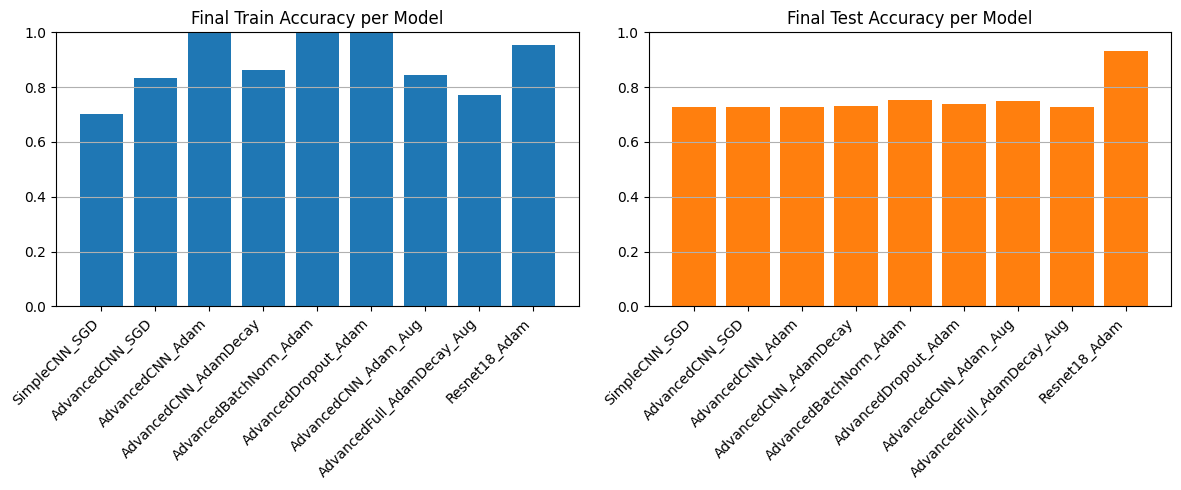

In [21]:
# Plot summary bar charts for final accuracies
names = list(model_performance.keys())
final_train = [model_performance[n]['final_train'] for n in names]
final_test = [model_performance[n]['final_test'] for n in names]

x = np.arange(len(names))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Train accuracies
axes[0].bar(x, final_train, color='C0')
axes[0].set_title('Final Train Accuracy per Model')
axes[0].set_xticks(x)
axes[0].set_xticklabels(names, rotation=45, ha='right')
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y')

# Test accuracies
axes[1].bar(x, final_test, color='C1')
axes[1].set_title('Final Test Accuracy per Model')
axes[1].set_xticks(x)
axes[1].set_xticklabels(names, rotation=45, ha='right')
axes[1].set_ylim(0, 1)
axes[1].grid(axis='y')

plt.tight_layout()
plt.savefig('figures/summary_final_accuracies.png');

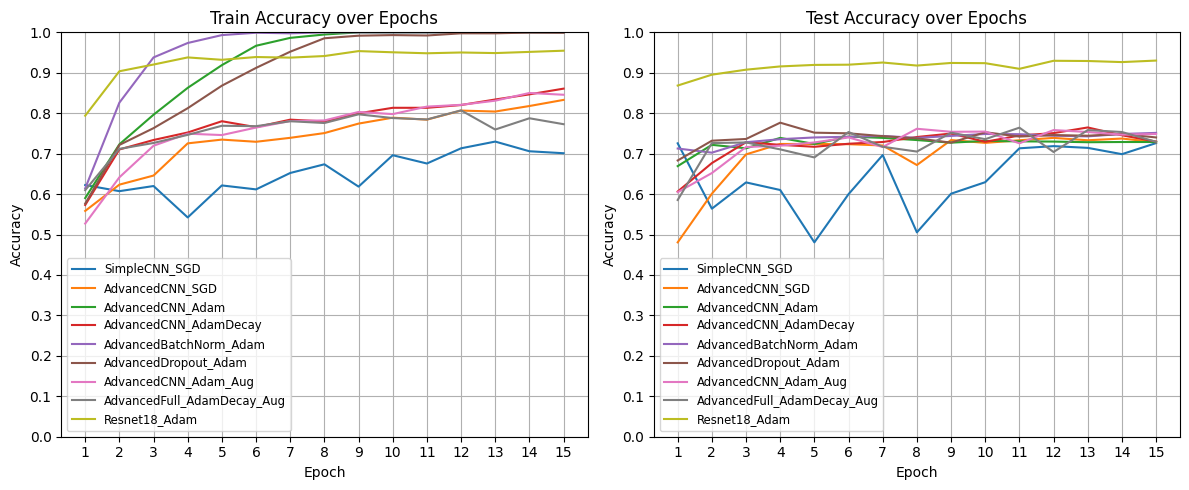

In [22]:
# Epoch-wise accuracy curves for all experiments (train and test)
epochs = np.arange(1, num_epochs + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for name, curves in model_performance.items():
    train_curve = curves['train_curve']
    test_curve = curves['test_curve']
    axes[0].plot(epochs, train_curve, label=name)
    axes[1].plot(epochs, test_curve, label=name)

axes[0].set_title('Train Accuracy over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(epochs)
axes[0].set_ylim(0,1)
axes[0].set_yticks(np.arange(0, 1.1, 0.1))
axes[0].grid()
axes[0].legend(fontsize='small', loc='best')

axes[1].set_title('Test Accuracy over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_xticks(epochs)
axes[1].set_ylim(0,1)
axes[1].set_yticks(np.arange(0, 1.1, 0.1))
axes[1].grid()
axes[1].legend(fontsize='small', loc='best')

plt.tight_layout()
plt.savefig('figures/epoch_accuracy_curves_all_models.png');